# One-way ANOVA

https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics.php

****


In [1]:
# Data frames.
import pandas as pd

# Plotting.
import seaborn as sns

# Stats.
import scipy.stats as ss

# Numerical arrays.
import numpy as np

# Collections.
import collections as co

# Specials.
import scipy.special as spec

## Example: Iris data 

****

In [5]:
df = pd.read_csv('https://github.com/ianmcloughlin/datasets/raw/main/iris.csv')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


## Assumption 1: Dependent variable
****

In [6]:
# The dependent variable.
dependent = df['sepal_length']
dependent

0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
      ... 
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: sepal_length, Length: 150, dtype: float64

In [7]:
dependent.describe()

count    150.000000
mean       5.843333
std        0.828066
min        4.300000
25%        5.100000
50%        5.800000
75%        6.400000
max        7.900000
Name: sepal_length, dtype: float64

## Assumption 2: Independent variable
****

In [9]:
# Independent variable.
independent = df['species']
independent

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

## Assumption 4: Outliers
****

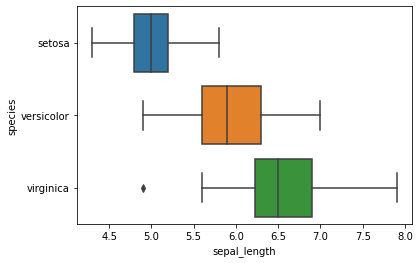

In [10]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
sns.boxplot(x=dependent, y=independent)

## Assumption 5: Normality

****
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

https://statistics.laerd.com/spss-tutorials/testing-for-normality-using-spss-statistics.php

In [24]:
# KDEs of the three categories.
sns.displot(x=dependent, hue=independent, kind="kde")

AttributeError: module 'seaborn' has no attribute 'displot'

In [13]:
# Extract the setosa sepal lengths.
sepal_len_setosa = dependent[independent == 'setosa']
sepal_len_setosa

0     5.1
1     4.9
2     4.7
3     4.6
4     5.0
5     5.4
6     4.6
7     5.0
8     4.4
9     4.9
10    5.4
11    4.8
12    4.8
13    4.3
14    5.8
15    5.7
16    5.4
17    5.1
18    5.7
19    5.1
20    5.4
21    5.1
22    4.6
23    5.1
24    4.8
25    5.0
26    5.0
27    5.2
28    5.2
29    4.7
30    4.8
31    5.4
32    5.2
33    5.5
34    4.9
35    5.0
36    5.5
37    4.9
38    4.4
39    5.1
40    5.0
41    4.5
42    4.4
43    5.0
44    5.1
45    4.8
46    5.1
47    4.6
48    5.3
49    5.0
Name: sepal_length, dtype: float64

In [14]:
# Run the Shapiro-Wilk test.
ss.shapiro(sepal_len_setosa)

ShapiroResult(statistic=0.9776989221572876, pvalue=0.4595281183719635)

In [15]:
# Run the test for the versicolors.
ss.shapiro(dependent[independent == 'versicolor'])

ShapiroResult(statistic=0.9778355956077576, pvalue=0.46473264694213867)

In [16]:
# Run the test for the virginica.
ss.shapiro(dependent[independent == 'virginica'])

ShapiroResult(statistic=0.9711798429489136, pvalue=0.25832483172416687)

## Assumption 6: Homogeneity of Variances
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php
****

In [17]:
# Test for equal variances.
ss.levene(
    dependent[independent == 'setosa'],
    dependent[independent == 'versicolor'],
    dependent[independent == 'virginica']
)

LeveneResult(statistic=6.35272002048269, pvalue=0.0022585277836218586)

## One-way ANOVA
Even though assumption 6 (and possible 4) are looking bad, we'll go ahead for learning purposes.
****

In [19]:
# ANOVA.
ss.f_oneway(
    dependent[independent == 'setosa'],
    dependent[independent == 'versicolor'],
    dependent[independent == 'virginica']
)

F_onewayResult(statistic=119.26450218450468, pvalue=1.6696691907693826e-31)

Conclusion: the mean sepal lengths of setosas, versicolors, and virginicas are different.

## Unequal Variances
https://github.com/scipy/scipy/issues/11122#issuecomment-587964214
****

In [20]:
def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = co.namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni = np.array([len(arg) for arg in args])
    mi = np.array([np.mean(arg) for arg in args])
    vi = np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = spec.fdtrc(dfbn, dfwn, f)   # equivalent to stats.f.sf
    return F_onewayResult(f, prob)

In [21]:
# Perform the test.
welch_anova_np(
    dependent[independent == 'setosa'],
    dependent[independent == 'versicolor'],
    dependent[independent == 'virginica']
)

F_onewayResult(statistic=138.90828526893796, pvalue=1.5050589627451774e-28)

Conclusion: the mean sepal lengths of setosas, versicolors, and virginicas are different.



# End